# EV State-Space Model

This  notebook is used to reproduce the State Space Model of aggregateed EV for frequency regulation.

Running on Jinning's local machine, in the env "ev".

Working notes:

02/06/2022: the EV data generation is completed. It looks weired, we may need update it later on.


In [42]:
import andes
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger(__name__)

print(f"ANDES Version: {andes.__version__}")

ANDES Version: 1.6.5.post60+ga84a2f4e


## EV data

### Define parameters

The EV parameters are defined as two types. Type I follows uniform distribution, which is stored in a Dict `ev_param`. Type II follows normal distribution, which is stored in a pd.DataFrame `ev_pdf`.

The data are cited from:

M. Wang et al., "State Space Model of Aggregated Electric Vehicles for Frequency Regulation," in IEEE Transactions on Smart Grid, vol. 11, no. 2, pp. 981-994, March 2020, doi: 10.1109/TSG.2019.2929052.

EVA:
tnow=10 [24H]
50000 EVs, 9678 online, Total En=1249.73 MWh, SoC intervals: 20
Online En=242.05 MWh, mean SoC=30.0%
EVA: Successfully reset to time=10


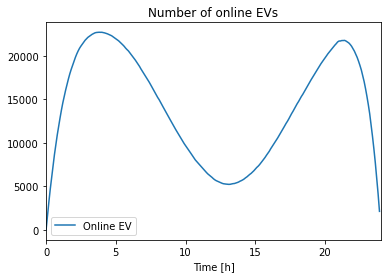

In [124]:
import scipy.stats as stats


def find_x(x, soc_intv):
    for idx in soc_intv.keys():
        if x >= soc_intv[idx][0] and x <= soc_intv[idx][1]:
            return idx


class ev_ssm():
    """
    EV State Space Model.

    EV parameters:
    Pc, Pd, nc, nd, En follow uniform distribution.
    soci, socd, ts, tf follows normal distribution.

    Attributes
    ----------
    ev: pandas.DataFrame
        EV dataset
        u: online status
        Pc/Pd: charging/discharging power (kW)
        nc/nd: charging/discharging efficiency
        En: capacity (kWh)
        soci/socd: initial/demand SOC (unit: %)
        ts/tf: start/finish time (unit: 24H)
        socx: SOC interval
    tnow: float
        current time (unit: 24H)
    N: int
        Total number of EVs
    Ns: int
        Total number of SoC intervals
    ne: int
        Online number of EVs

    Notes
    -----
    ev_ufparam:
        Pl: rated charging/discharging power (kW) lower bound
        Pu: rated charging/discharging power (kW) upper bound
        nl: charging/discharging efficiency lower bound
        nu: charging/discharging efficiency upper bound
        Enl: Battery capacity (kWh) lower bound
        Enu: Battery capacity (kWh) upper bound
        socl: Minimum SoC value
        socu: Maximum SoC value
    ev_nfparam:
        soci: initial SoC
        socd: demanded SoC
        ts1: start charging time, [24H]
        ts2: start charging time, [24H]
        tf1: finish charging time, [24H]
        tf2: finish charging time, [24H]
    """

    def find_socx(self):
        self.ev['socx'] = self.ev['soc'].apply(lambda x: find_x(x, self.soc_intv))

    def build(self):
        """
        Build the ev DataFrame.

        Returns
        -------
        ev: pandas.DataFrame
            EV dataset
        """
        self.socl = self.ev_ufparam['socl']
        self.socu = self.ev_ufparam['socu']

        #  --- 1a. uniform distribution parameters range ---
        unit = self.ev_ufparam['socu']/self.ev_ufparam['Ns']
        self.soc_intv = {}
        decimal = 4
        for i in range(self.ev_ufparam['Ns']):
            intv_single = [np.around(i*unit, decimal), np.around((i+1)*unit, decimal)]
            self.soc_intv[i] = intv_single
        self.Ns = self.ev_ufparam['Ns']
        ev_pdf = pd.DataFrame(data=self.ev_pdf_data, index=self.ev_pdf_name).transpose()
        self.ev_nfparam = ev_pdf.to_dict()

        # --- 1c. generate EV dataset ---
        self.ev = pd.DataFrame()
        np.random.seed(self.seed)

        #  data from uniform distribution
        cols = ['Pc', 'Pd', 'nc', 'nd', 'En']
        cols_bound = {'Pc':   ['Pl', 'Pu'],
                      'Pd':   ['Pl', 'Pu'],
                      'nc':   ['nl', 'nu'],
                      'nd':   ['nl', 'nu'],
                      'En':    ['Enl', 'Enu']}
        for col in cols:
            idxl = cols_bound[col][0]
            idxh = cols_bound[col][1]
            self.ev[col] = np.random.uniform(
                low=self.ev_ufparam[idxl],
                high=self.ev_ufparam[idxh],
                size=self.N)

        #  data from normal distribution
        # soci, socd
        for col in self.ev_pdf_name:
            self.ev[col] = stats.truncnorm(
                (ev_pdf[col]['lb'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                (ev_pdf[col]['ub'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                loc=ev_pdf[col]['mean'], scale=ev_pdf[col]['var']).rvs(self.N)
        self.ev['soc'] = self.ev['soci']
        # ts1, ts2, tf1, tf2
        et = self.ev.copy()
        r1 = 0.5  # ratio of t1
        tp1 = self.ev[['ts1', 'tf1']].sample(n=int(et.shape[0]*r1), random_state=2021)
        tp2 = self.ev[['ts2', 'tf2']].sample(n=int(et.shape[0]*(1-r1)), random_state=2021)
        tp = pd.concat([tp1, tp2], axis=0).reset_index(drop=True).fillna(0)
        tp['ts'] = tp['ts1'] + tp['ts2']
        tp['tf'] = tp['tf1'] + tp['tf2']
        check = tp.ts > tp.tf
        row_idx = tp[check].index
        mid = tp.tf.iloc[row_idx].values
        tp.tf.iloc[row_idx] = tp.ts.iloc[row_idx]
        tp.ts.iloc[row_idx] = mid
        check = tp.ts > tp.tf
        self.ev['ts'] = tp['ts']
        self.ev['tf'] = tp['tf']
        self.ev['u'] = 1
        self.ev = self.ev[['u', 'Pc', 'Pd', 'nc', 'nd', 'En', 'soc', 'soci', 'socd', 'ts', 'tf']]

        # --- update soc interval and online status ---
        self.find_socx()
        self.g_u()
        self.ne = self.ev.u.sum()

    def __init__(self, tnow=0, N=20000, seed=2021, name="EVA"):
        """
        Parameters
        ----------
        N: int
            Number of EVs
        seed: int
            Random seed
        """
        # --- 1. init ---
        self.name = name
        self.tnow = tnow  # time now
        self.N = N
        self.seed = seed
        # --- 1a. uniform distribution parameters range ---
        self.ev_ufparam = dict(Ns=20,
                               Pl=5.0, Pu=7.0,
                               nl=0.88, nu=0.95,
                               Enl=20.0, Enu=30.0,
                               socl=0, socu=1)
        #  --- 1b. normal distribution parameters range ---
        self.ev_pdf_name = ['soci', 'socd', 'ts1', 'ts2', 'tf1', 'tf2']
        self.ev_pdf_data = {'mean':     [0.3,    0.8,    -6.5,   17.5,   8.9,    32.9],
                            'var':      [0.05, 0.03, 3.4, 3.4, 3.4, 3.4],
                            'lb':       [0.2, 0.7, 0.0, 5.5, 0.0, 20.9],
                            'ub':       [0.4, 0.9, 5.5, 24.0, 20.9, 24.0],
                            'info':  ['initial SoC', 'demanded SoC',
                                      'start charging time 1', 'start charging time 2',
                                      'finish charging time 1', 'finish charging time 2']}
        self.build()
        self.report()

        # --- SSM ---
        # --- input: AGC signal ---

        # --- output: estimated FRC ---
        self.prumax = 0
        self.prdmax = 0

    def report(self):
        """
        Report EVA.
        """
        # --- EV summary info ---
        self.En = self.ev.En.sum()/1e3
        self.wEn = np.sum(self.ev.u * self.ev.En)/1e3
        # --- report info ---
        msg1 = f"{self.name}:\n"
        msg_time = f'tnow={np.round(self.tnow, 4)} [24H]\n'
        msg_ev = f"{self.N} EVs, {self.ne} online, Total En={self.En.round(2)} MWh, SoC intervals: {len(self.soc_intv)}\n"
        msg_soc = f"Online En={self.wEn.round(2)} MWh, mean SoC={100*self.ev.soc.mean().round(2)}%"
        logger.warning(msg1 + msg_time + msg_ev + msg_soc)

    def act(self, t=4, tnow=10):
        """
        Response of the EV_SSM to the control signal.

        Parameters
        ----------
        t: int
            Action time (second).
        tnow: int
            current time (hour with decimals).
        """
        self.tnow = tnow
        self.g_ctrl()  # generate charging signal
        self.g_u()  # update online status
        # charging/discharging power, kW
        self.ev['dP'] = self.ev[['Pc', 'Pd', 'nc', 'nd', 'ctrl', 'u']].apply(
            lambda x: x[0]*x[2]*x[5] if x[4] >= 0 else -1*x[1]*x[3]*x[5], axis=1)
        self.ev['dP'] = self.ev['dP'] * self.ev['u']  # consider online status
        self.ev['soc'] = self.ev.soc + t/3600 * self.ev['dP'] / self.ev['En']  # update SoC
        self.ev['soc'] = self.ev['soc'].apply(lambda x: x if x < self.socu else self.socu)
        self.ev['soc'] = self.ev['soc'].apply(lambda x: x if x > self.socl else self.socu)
        self.find_socx()

    def g_u(self, tnow=10):
        """
        Update online status of EV at given time.

        Parameters
        ----------
        tnow: int
            current time (hour with decimals).
        """
        self.tnow=tnow
        self.ev['u'] = (self.ev.ts <= self.tnow) & (self.ev.tf >= self.tnow)
        self.ev['u'] = self.ev['u'].astype(int)
        self.ne = self.ev.u.sum()

    def g_ctrl(self):
        """
        Generate the charging signal.
        """
        # --- default signal is charging for all ---
        # TODO: replace with SSM later on
        self.ev['ctrl'] = np.ones(self.ne)
        # self.ev['ctrl'] = np.random.choice([-1, 0, 1], size=self.ne)

    def reset(self, tnow=10):
        """
        Reset the EV_SSM to before charging state.

        Parameters
        ----------
        tnow: float
            current time (hour with decimals).
        """
        self.ev.soc = self.ev.soci
        self.tnow = tnow
        self.g_u()
        self.find_socx()
        logger.warning(f"{self.name}: Successfully reset to time={self.tnow}")

# initialize
sse = ev_ssm(N=50000, tnow=10)

# --- plot online EV numbers ---
time = np.arange(0, 24, 0.1)
num = []
for t in time:
    sse.g_u(t)
    num.append(sse.ne)

fig, ax = plt.subplots()
ax.plot(time, num)
ax.set_title('Number of online EVs')
ax.set_xlabel('Time [h]')
ax.legend(['Online EV', 'Online capacity'])
ax.set_xlim(0, 24)

# reset sse
sse.reset(tnow=10)


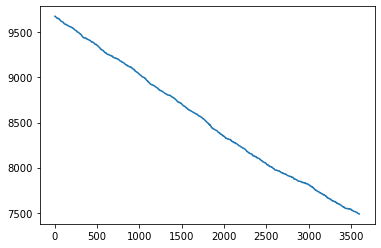

In [3]:
# Online EV numbers during hour 10
num = []
for i in range(3600):
    sse.g_u(tnow=10+i/3600)
    num.append(sse.ev.u.sum())
plt.plot(range(3600), num)

## SSM Matrix

In [39]:
soc_res = pd.DataFrame()
soc_s = pd.DataFrame()
for i, t in enumerate(range(0, 3600*10+1, 300)):
    t = t/3600
    sse.act(t=300, tnow=t)
    soc_s['col'] = sse.ev.socx.values
    soc_res = pd.concat([soc_res, soc_s], axis=0)


In [41]:
sse.ev.u.sum()

9678

In [16]:
from hmmlearn import hmm

In [23]:
ssm = hmm.GaussianHMM(n_components=20, covariance_type="full", n_iter=100)

In [24]:
ssm.fit(soc_res.values)

ValueError: 'covars' must be symmetric, positive-definite

In [22]:
ssm.predict(sse.ev.socx.values)

ValueError: Expected 2D array, got 1D array instead:
array=[ 9  5 10 ...  5  5  5].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
A = np.zeros((sse.Ns, sse.Ns))
B1 = -1 * np.ones((sse.Ns, sse.Ns))
B2 = np.eye(sse.Ns)
B3 = np.zeros((sse.Ns, sse.Ns))
B = np.vstack((B1, B2, B3))

C1 = np.zeros((sse.Ns, sse.Ns))
C2 = -1 * np.eye(sse.Ns)
C3 = np.ones((sse.Ns, sse.Ns))
C = np.vstack((C1, C2, C3))

Pave = 1 # TODO: average power of online EV
D1 = -1 * np.ones((1, sse.Ns))
D2 = np.zeros((1, sse.Ns))
D3 = np.ones((1, sse.Ns))
D = Pave * np.hstack((D1, D2, D3))
D

In [ ]:
np.matrix

## Simulation

Issues: how to integerate the SSM when using ADNES?

flow_chart:
```{python}
prep grid data:
ADNES: topology,  gen. limits, ramp. limits, line limits,
Outside: gen. cost, ramp. cost,

for $t_{OPF}$ in T (interval: 5min; total: 1h; [n=12]):
    aggregate EV data (from SSM), generate $PR_{e,i,u,t}$
    Do OPF, generate $PG_{i, t}$, $PR_{g, i, u, t}$, $PR_{g, i, d, t}$

    for t in $t_{OPF}$ (interval: 4s; total: 5min; [n=75]):
        Update data into dynamic system:
            # Note, constant power model should be used in TDS.
            # Use TimeSeries as the load. 
            power change: TGOV1.paux0
            load change: 

        Run TDS: generate SFR mileage
```

Co-Sim list:
```{python}
for $t_{OPF}$ in T:
    EVA report $pru_{max}$ $prd_{max}$, eqn xxx
    TCC do OPF, eqn xxx
    Assign dispatch signal to generation units

    for t in $t_{AGC}$:
        Assign AGC signal to AGC units
        Run TDS
```